# Analysis of the Colorfulness of the Documents/Images

Colorfulness in increasing order:

1. MyDoc (business documents, in general)
2. MyCharts
3. MyInfographics

Results show that these three datasets are indeed significantly visually different--indicating the need for different models for the three.

In [ ]:
# !pip install -q seaborn

In [ ]:
import os

import lancedb
import cv2
import numpy as np
import seaborn as sns
from PIL import Image

## Load VectorDB

In [3]:
uri = "data/lancedb"
db = lancedb.connect(uri)

In [4]:
mmfm_table = db.open_table("mmfm")

In [5]:
df_mmfm = mmfm_table.to_pandas()

## Document Colorfulness

In [21]:
def calculate_colorfulness(image_path):
    # Source: ChatGPT. https://chatgpt.com/share/b42b3ac2-0c27-45d8-a36c-1bb182dc589c

    # Load the image
    # image = cv2.imread(image_path)
    # Open image using PIL to handle GIFs
    image = np.array(Image.open(image_path).convert('RGB'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split into L, A and B channels
    L, A, B = cv2.split(image)

    # Compute the mean and standard deviation of the A and B channels
    (mean_a, stddev_a) = (np.mean(A), np.std(A))
    (mean_b, stddev_b) = (np.mean(B), np.std(B))

    # Compute the colorfulness metric
    colorfulness = np.sqrt(stddev_a**2 + stddev_b**2) + 0.3 * np.sqrt(mean_a**2 + mean_b**2)

    return colorfulness

### Unit tests

In [ ]:
image_path = df_mmfm[df_mmfm["dataset"] == "myinfographic"].iloc[0]["image"]
image_path = f"data/raw_datasets/myinfographic/images/{image_path}"
image_path

In [23]:
colorfulness = calculate_colorfulness(image_path)
print(f"Colorfulness: {colorfulness}")

Colorfulness: 87.88750750297267


In [24]:
image_path = df_mmfm[df_mmfm["dataset"] == "mydoc"].iloc[0]["image"]
image_path = f"data/raw_datasets/mydoc/images/{image_path}"
image_path

'data/raw_datasets/mydoc/images/2475c566901d68a77a8f16cfa498cb165201890e980fa2c4aa1e1e9c8c60fbc8.png'

In [25]:
colorfulness = calculate_colorfulness(image_path)
print(f"Colorfulness: {colorfulness}")

Colorfulness: 55.45812146280156


### Calculate colorfulness of Phase 2 docs only

In [26]:
df_mmfm_sample = df_mmfm[
    (df_mmfm["dataset"] == "myinfographic") |
    (df_mmfm["dataset"] == "mydoc") |
    (df_mmfm["dataset"] == "mychart")
].copy()
df_mmfm_sample["image_path"] = "data/raw_datasets/" + df_mmfm_sample["dataset"] + "/images/" + df_mmfm_sample["image"]

#### Sanity check

In [27]:
for image_path in df_mmfm_sample["image_path"].tolist():
    if not os.path.exists(image_path):
        print(image_path)

#### Actual computation

In [ ]:
%%time
colorfulness = []
for idx, image_path in enumerate(df_mmfm_sample["image_path"].tolist()):
    try:
        colorfulness.append(calculate_colorfulness(image_path))
    except Exception as e:
        print(e, image_path)
        colorfulness.append(100)

In [29]:
df_mmfm_sample["colorfulness"] = colorfulness

### Analyze doc colorfulness

<Axes: xlabel='colorfulness', ylabel='Count'>

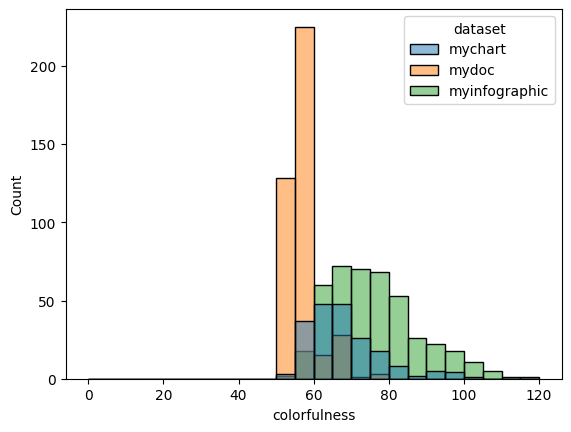

In [40]:
sns.histplot(df_mmfm_sample, x="colorfulness", hue="dataset", binwidth=5, binrange=(0, 120))

In [ ]:
df_mmfm_sample[df_mmfm_sample["dataset"] == "mydoc"]["colorfulness"].mean()

In [42]:
df_mmfm_sample[df_mmfm_sample["dataset"] == "mychart"]["colorfulness"].mean()

67.98594050804765

In [43]:
df_mmfm_sample[df_mmfm_sample["dataset"] == "myinfographic"]["colorfulness"].mean()

75.95772679951709

In [54]:
idx = df_mmfm_sample[df_mmfm_sample["dataset"] == "mydoc"]["colorfulness"].argmax()
idx

42

In [ ]:
df_mmfm_sample[df_mmfm_sample["dataset"] == "mydoc"].iloc[idx]["conversations"]

In [ ]:
df_mmfm_sample[df_mmfm_sample["dataset"] == "mydoc"].iloc[idx]["image_path"]

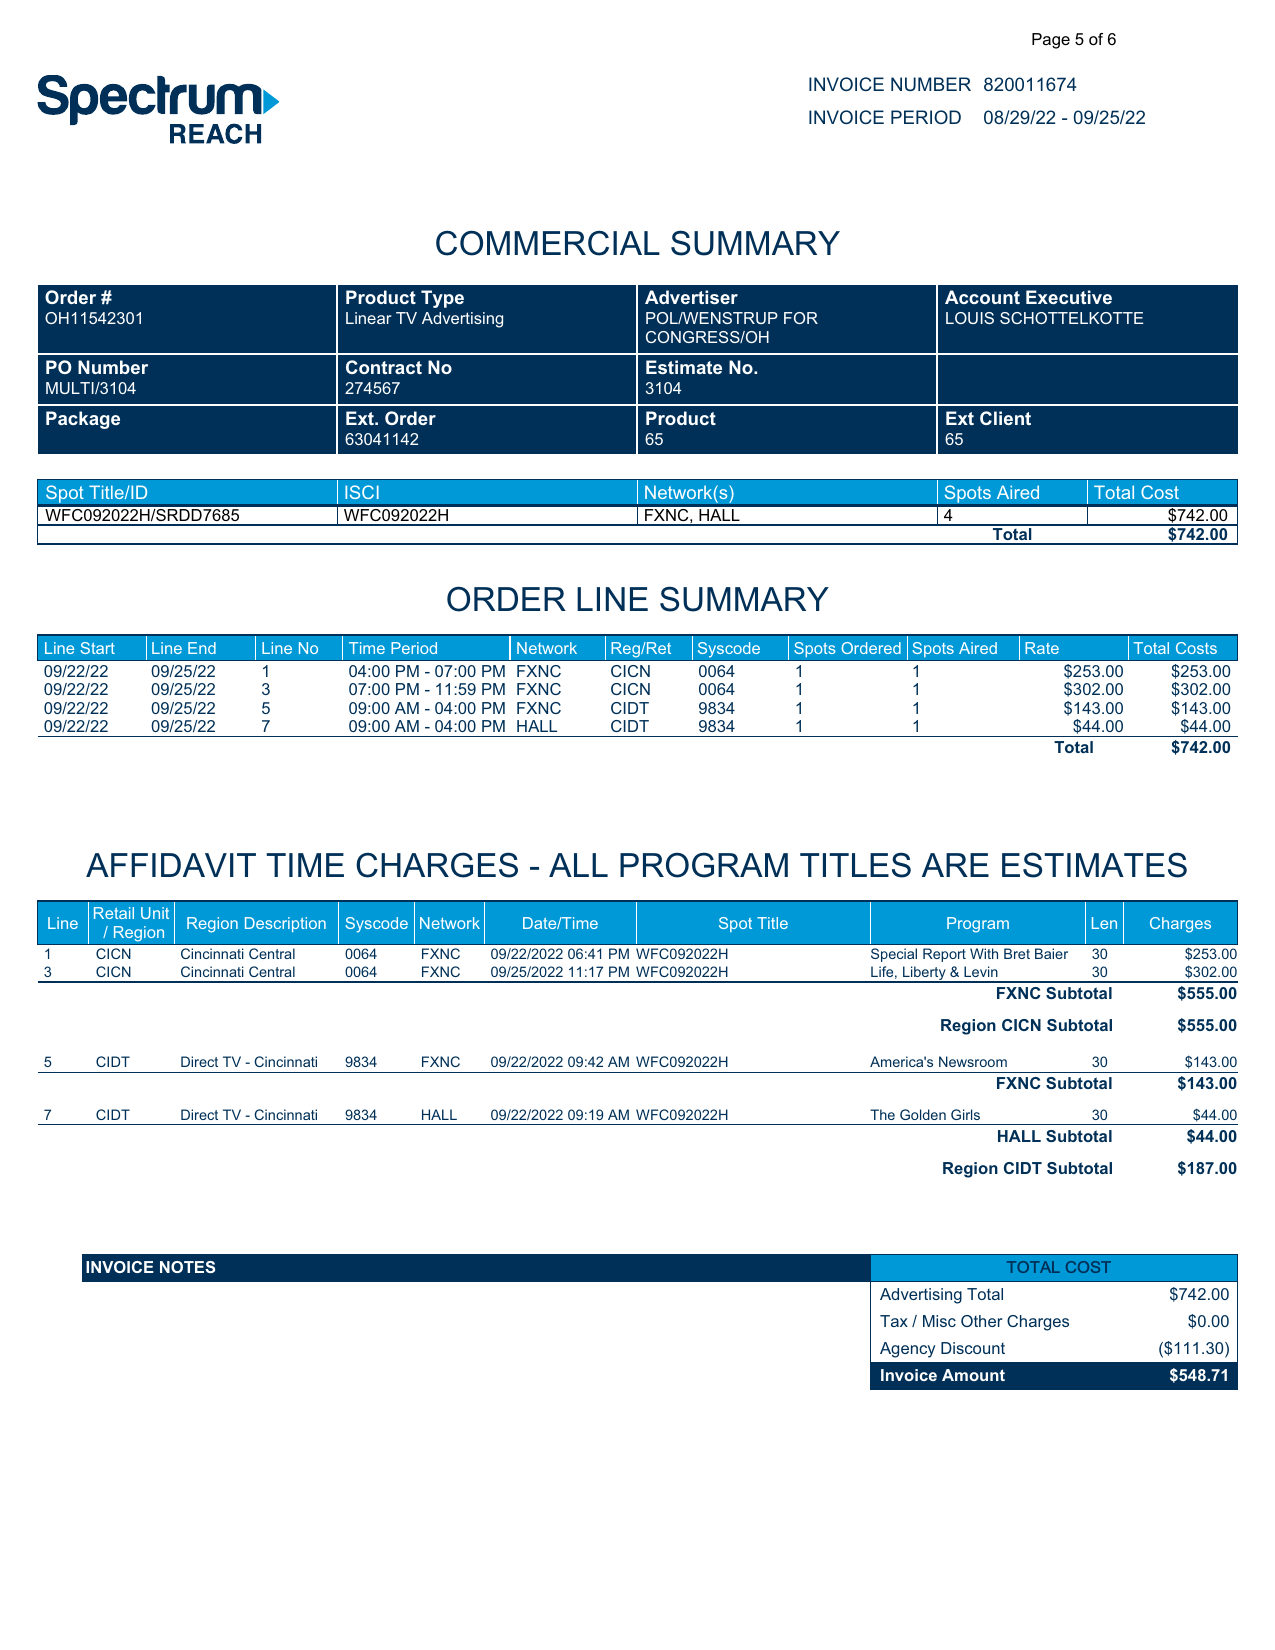

In [55]:
Image.open(df_mmfm_sample[df_mmfm_sample["dataset"] == "mydoc"].iloc[idx]["image_path"])

In [49]:
idx = df_mmfm_sample[df_mmfm_sample["dataset"] == "myinfographic"]["colorfulness"].argmin()
idx

20

In [58]:
df_mmfm_sample[df_mmfm_sample["dataset"] == "myinfographic"].iloc[idx]["conversations"]

array([{'from': 'human', 'value': '<image>\nWhat kind of technology advancements might a makeup and mehndi studio like this one utilize?'}],
      dtype=object)

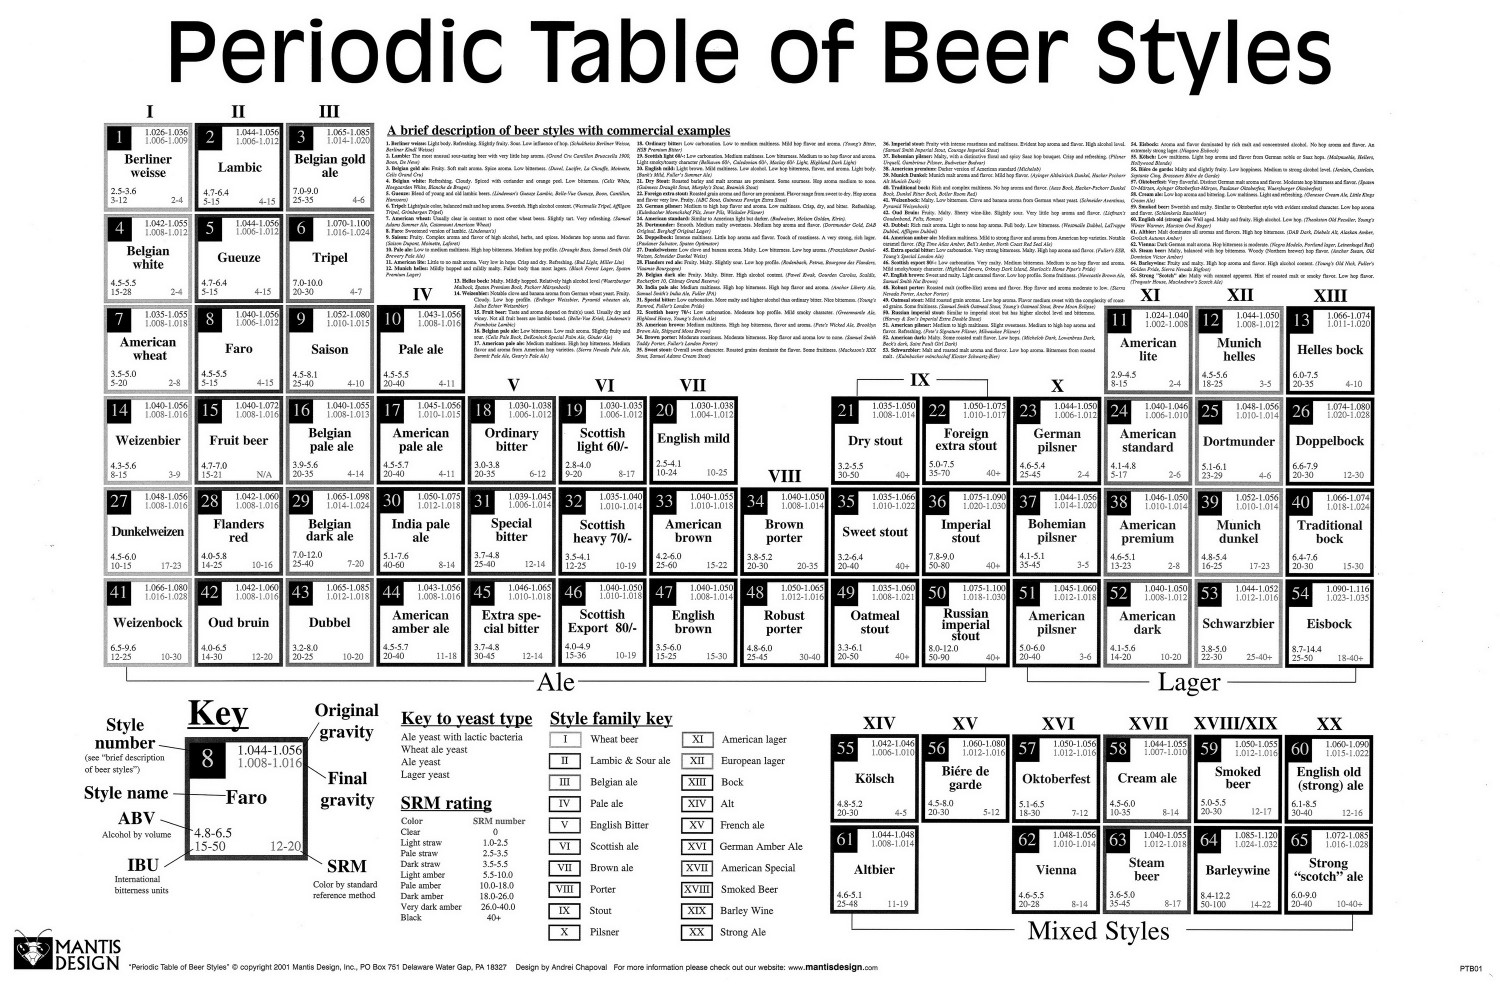

In [53]:
Image.open(df_mmfm_sample[df_mmfm_sample["dataset"] == "myinfographic"].iloc[idx]["image_path"])

## Save doc colorfulness to VectorDB

In [ ]:
df_mmfm_sample.tail(3)

In [61]:
mmfm_table.merge_insert("id") \
    .when_matched_update_all() \
    .when_not_matched_insert_all() \
    .execute(df_mmfm_sample)

In [ ]:
mmfm_table.to_pandas()